# **Problem Statement:**
Identify which questions asked on Quora are duplicates of questions that have already been asked.


*   This can be helpful for providing instant responses to questions that have already been addressed.




# **Objective:**
The goal of this project is to predict which of the provided pairs of questions contain two questions with the same meaning. 
# Real World/Business Objectives and Constraints:






*   The cost of a mis-classification can be very high.
*   You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
*   No strict latency concerns.
*   Interpretability is partially important.





# **About Dataset**

The dataset "Train.csv" contains **404,290 rows**and **5 columns**

#Data fields
**id** - the id of a training set question pair

**qid1, qid2** - unique ids of each question (only available in train.csv)

**question1, question2** - the full text of each question

**is_duplicate** - is the dependent variable, and the target variable is set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

> Load the Dataset

In [2]:
df = pd.read_csv('train.csv')

> Check the Shape of dataset

In [3]:
df.shape

(404290, 6)

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


> Check the meta information about the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
print("Available Columns : ", df.columns)
print("\nis_duplicates Class labels",df.is_duplicate.unique())
print("\nNo. of non-duplicate data points(0) and No. of duplicate data points(1) are :\n")
df.is_duplicate.value_counts()

Available Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

is_duplicates Class labels [0 1]

No. of non-duplicate data points(0) and No. of duplicate data points(1) are :



0    255027
1    149263
Name: is_duplicate, dtype: int64

# Distribution of data points among output classes

Number of duplicate(similar) and non-duplicate(non similar) questions

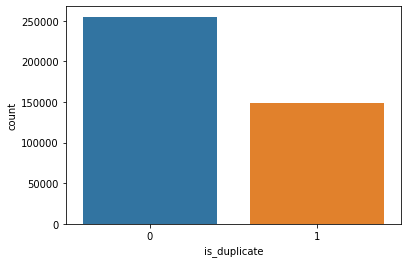

In [7]:
sns.countplot(df["is_duplicate"])
plt.show()

In [8]:
print('Percentage of dissimilar pair of questions (is_duplicate = 0): {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\nPercentage of similar pair of questions (is_duplicate = 1): {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Percentage of dissimilar pair of questions (is_duplicate = 0): 63.08%

Percentage of similar pair of questions (is_duplicate = 1): 36.92%


> **63.08%** of questions pair are not duplicates and **36.92%** of question pairs are duplicates.

> We have 404290 training data points. And only 36.92% are positive. That means it is an imbalanced dataset.

In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
repeated_qids = np.sum(qids.value_counts() > 1)
print("Total no. unique qids: ", unique_qids)
print("\nToatal no. of repeated qids: ", repeated_qids)

Total no. unique qids:  537933

Toatal no. of repeated qids:  111780


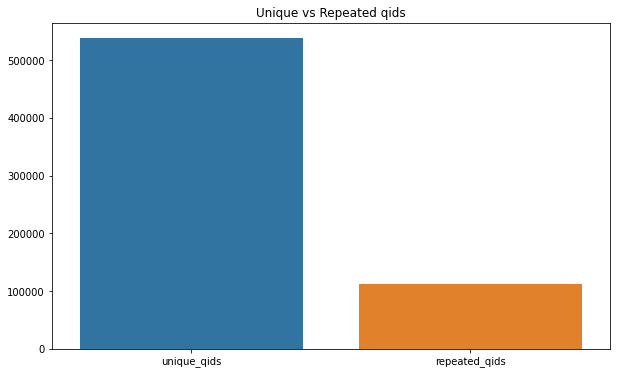

In [10]:
x = ["unique_qids" , "repeated_qids"]
y =  [unique_qids , repeated_qids]

plt.figure(figsize=(10, 6))
plt.title ("Unique vs Repeated qids")
sns.barplot(x,y)
plt.show()

> Let's check whether there are any repeated pair of questions.

In [11]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate pair of questions:",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate pair of questions: 0


> Let us visually plot the no. of times a question is repeated.

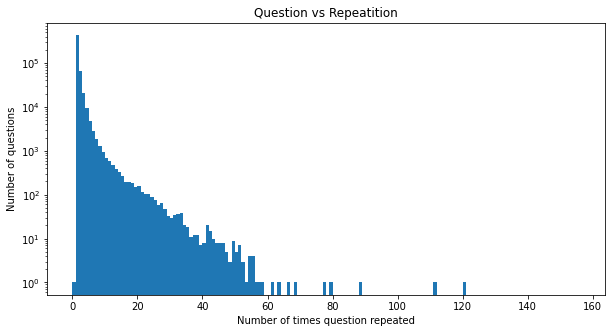

0 157


In [12]:
occurences = np.bincount(qids)
plt.figure(figsize=(10,5)) 
plt.hist(occurences, bins=range(0,np.max(occurences)))
plt.yscale('log')
plt.xlabel('Number of times question repeated')
plt.ylabel('Number of questions')
plt.title('Question vs Repeatition')
plt.show()
print(np.min(occurences), np.max(occurences))

*      When we include both question1 and question2 then count of total number of questions are 808574.
*      Out of these 808574 questions 537929 are unique questions and rest are repeated questions.
*      Most of the questions are repeated very few times. Only a few of them are repeated multiple times.
*      And we can notice that there is One question which is the most repeated one and it is repeated 157 times.
*      There are some questions with very few characters, which does not make sense. It will be taken care of later with Data Cleaning.

> Check whether there are any rows with null values.

In [13]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

> As we notice they are total 3 null values 1 in question1 and 2 in question2,  let us print those null rows

In [14]:
null_rows = df[df.isnull().any(1)]
print (null_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


> Fill the null rows with ' '

In [15]:
df = df.fillna('')

> Check wheather null rows are filled.

In [16]:
null_rows = df[df.isnull().any(1)]
print (null_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [17]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

> As we notice know the null rows are filled i.e, our dataset doesn't contain any more null rows

In [18]:
df.duplicated().sum()

0

> There are no duplicates in our dataset

# Sampling 3000 data points to enhance training speed and optimize memory usage.

In [19]:
new_df = df.sample(3000,random_state=2)

# **Basic EDA**

In [20]:
new_df.shape

(3000, 6)

In [21]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


> Check the meta information about the dataset

In [22]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 398782 to 262016
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3000 non-null   int64 
 1   qid1          3000 non-null   int64 
 2   qid2          3000 non-null   int64 
 3   question1     3000 non-null   object
 4   question2     3000 non-null   object
 5   is_duplicate  3000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 164.1+ KB


In [23]:
print("\nis_duplicates Class labels",new_df.is_duplicate.unique())
print("\nNo. of non-duplicate data points(0) and No. of duplicate data points(1) are :\n")
new_df.is_duplicate.value_counts()


is_duplicates Class labels [1 0]

No. of non-duplicate data points(0) and No. of duplicate data points(1) are :



0    1882
1    1118
Name: is_duplicate, dtype: int64

In [24]:
print('Percentage of dissimilar pair of questions (is_duplicate = 0): {}%'.format(100 - round(new_df['is_duplicate'].mean()*100, 2)))
print('\nPercentage of similar pair of questions (is_duplicate = 1): {}%'.format(round(new_df['is_duplicate'].mean()*100, 2)))

Percentage of dissimilar pair of questions (is_duplicate = 0): 62.73%

Percentage of similar pair of questions (is_duplicate = 1): 37.27%


> **62.73%** of questions pair are not duplicates and **37.27%** of question pairs are duplicates in sample dataframe(new_df).

> That means it is an imbalanced dataset.

# Distribution of data points among output classes

Number of duplicate(smilar) and non-duplicate(non similar) questions

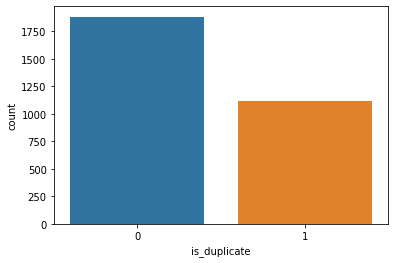

In [25]:
sns.countplot(new_df["is_duplicate"])
plt.show()

In [26]:
qids = pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())
unique_qids = len(np.unique(qids))
repeated_qids = np.sum(qids.value_counts() > 1)
print("Total no. unique qids: ", unique_qids)
print("\nToatal no. of repeated qids: ", repeated_qids)

Total no. unique qids:  5929

Toatal no. of repeated qids:  65


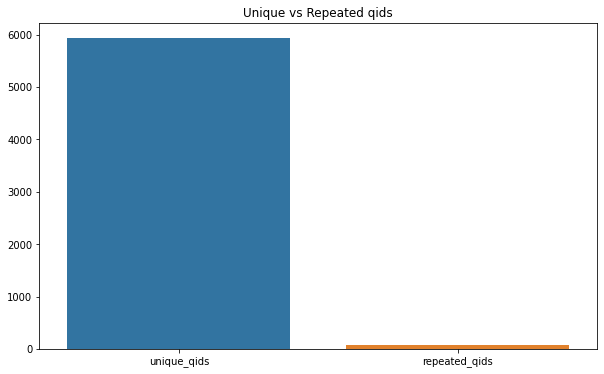

In [27]:
x = ["unique_qids" , "repeated_qids"]
y =  [unique_qids , repeated_qids]

plt.figure(figsize=(10, 6))
plt.title ("Unique vs Repeated qids")
sns.barplot(x,y)
plt.show()

> Let's check whether there are any repeated pair of questions.

In [28]:
pair_duplicates = new_df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate pair of questions:",(pair_duplicates).shape[0] - new_df.shape[0])

Number of duplicate pair of questions: 0


# **Data Preprocessing**
Perform below actions on question1 and question2 columns of the dataset:
*   Convert entire text to lowercase
*   Remove html tags
*   Remove Stopwords
*   Expand Contractions
*   Remove Punctuations
*   Remove Special Characters
*   Remove hyperlinks
*   Apply Tokenization
*   Apply Stemming
*   Apply Lemmatization


In [29]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
## initialise the inbuilt Stemmer
stemmer = PorterStemmer()

In [31]:
## We can also use Lemmatizer instead of Stemmer
lemmatizer = WordNetLemmatizer()

In [32]:
def preprocess(q, flag):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    
    # Stemming/Lemmatization
    if(flag == 'stem'):
        q = stemmer.stem(q)
    else:
        q = lemmatizer.lemmatize(q)
        
    return q
    # tokenize into words
    #tokens = q.split()
    
    # remove stop words                
    #clean_tokens = [t for t in tokens if not t in stopwords.words("english")]
    

    # Stemming/Lemmatization
    #if(flag == 'stem'):
        #clean_tokens = [stemmer.stem(word) for word in clean_tokens]
    #else:
        #clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]

    #q=' '.join([" ".join(clean_tokens)])
    #return q

In [33]:
q1 = 'Where is the capital of India?'
preprocess(q1,'lem')

'where is the capital of india'

In [34]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from tqdm import tqdm, tqdm_notebook

In [36]:
# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`

tqdm.pandas()

> Add new columns "**clean_q1_stem**","**clean_q2_stem**" to the dataframe new_df.
> where, 
- **clean_q1_stem** column represents preprocessed_q1 column after applying preprocess function with flag=Stem 
- **clean_q2_stem** column represents preprocessed_q2 column after applying preprocess function with flag=Stem

> Add new columns "**clean_q1_lem**","**clean_q2_lem**" to the dataframe new_df.
> where, 
- **clean_q1_lem** column represents preprocessed_q1 column after applying preprocess function with flag=lem
- **clean_q2_lem** column represents preprocessed_q2 column after applying preprocess function with flag=lem

In [37]:
#temp_df = X_train['question1'].progress_apply(lambda x: preprocess(x, 'stem'))

new_df['Clean_q1_stem'] = new_df['question1'].progress_apply(lambda x: preprocess(x,'Stem'))
new_df['Clean_q2_stem'] = new_df['question2'].progress_apply(lambda x: preprocess(x,'Stem'))

new_df['Clean_q1_lem'] = new_df['question1'].progress_apply(lambda x: preprocess(x,'lem'))
new_df['Clean_q2_lem'] = new_df['question2'].progress_apply(lambda x: preprocess(x,'lem'))
new_df.head()

100%|██████████| 3000/3000 [00:00<00:00, 3113.02it/s]


,id,qid1,qid2,question1,question2,is_duplicate,Clean_q1_stem,Clean_q2_stem,Clean_q1_lem,Clean_q2_lem
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,what is the best marketing automation tool for...,what is the best marketing automation tool for...,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


# Word Clouds

In [38]:
from random import randint
from wordcloud import WordCloud, STOPWORDS

In [39]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)
    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(10, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

# Word Cloud for Preprocessed question1

Word Cloud for preprocesssed question1:


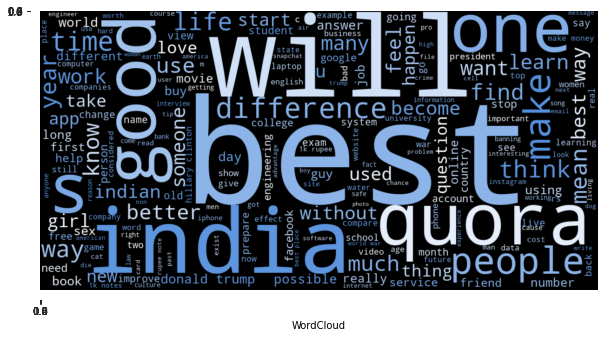

In [40]:
print("Word Cloud for preprocesssed question1:")
plot_wordcloud(' '.join(new_df.Clean_q1_lem	.values.tolist()), wc_blue_color_func)

# Word Cloud for Preprocessed question2

Word Cloud for preprocessed question2:


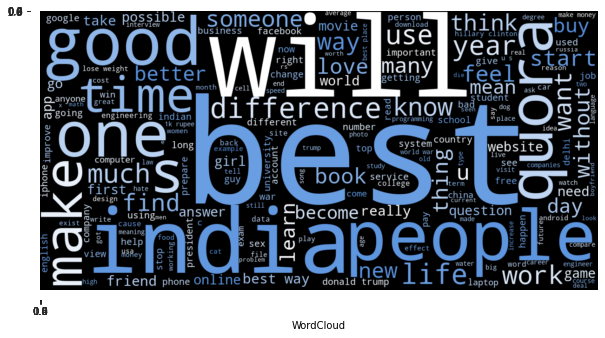

In [41]:
print("Word Cloud for preprocessed question2:")
plot_wordcloud(' '.join(new_df.Clean_q2_lem	.values.tolist()), wc_blue_color_func)

# Work Cloud for Duplicate Question Pairs

Word Cloud for Duplicate Question pairs


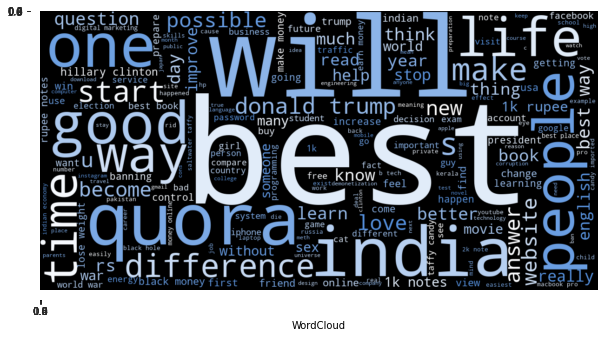

In [42]:
print ("Word Cloud for Duplicate Question pairs")
plot_wordcloud(' '.join(new_df['Clean_q1_lem'].loc[new_df['is_duplicate'] == 1].values.tolist() and new_df['Clean_q2_lem'].loc[new_df['is_duplicate'] == 1].values.tolist()), wc_blue_color_func)

# Work Cloud for Non-Duplicate Question Pairs

Word Cloud for Non-Duplicate Question pairs


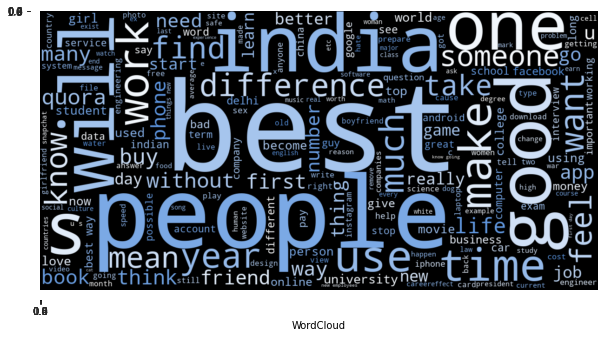

In [43]:
print ("Word Cloud for Non-Duplicate Question pairs")
plot_wordcloud(' '.join(new_df['Clean_q1_lem'].loc[new_df['is_duplicate'] == 0].values.tolist() and new_df['Clean_q2_lem'].loc[new_df['is_duplicate'] == 0].values.tolist()), wc_blue_color_func)

# Plot count of length of words in Clean_q1_lem and Clean_q2_lem

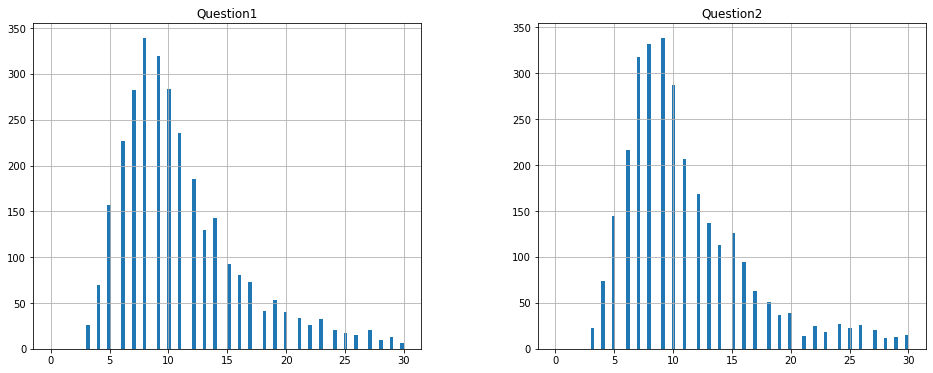

In [44]:
Question1_count = [len(sentence.split()) for sentence in new_df.Clean_q1_lem]
Question2_count = [len(sentence.split()) for sentence in new_df.Clean_q2_lem]

pd.DataFrame({'Question1':Question1_count, 'Question2': Question2_count}).hist(bins=100, figsize=(16, 6), range=[0, 30])
plt.show()

In [45]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


print("Percentage of Question1 having 0-30 words: ",get_word_percent(new_df.Clean_q1_lem,30 ))
print("\nPercentage of Question1 having 0-15 words: ",get_word_percent(new_df.Clean_q1_lem,15 ))

print("\nPercentage of Question2 having 0-30 words: ",get_word_percent(new_df.Clean_q2_lem, 30))
print("\nPercentage of Question2 having 0-15 words: ",get_word_percent(new_df.Clean_q2_lem, 15))

Percentage of Question1 having 0-30 words:  0.99

Percentage of Question1 having 0-15 words:  0.83

Percentage of Question2 having 0-30 words:  0.99

Percentage of Question2 having 0-15 words:  0.83


> We can notice that almost 99% of words are in range 0 to 15 for both Question1 and Question2.

> And they are very few questions in both Question1 and Question2 that have count of words greater than 15.

# **Feature Extraction**
we have divided this step in three parts
1. **Basic Features** : These features are extracted from preprocessed question1 and question2 and are stored in new dataframe named "bf_df"(where bf represents basic features)
2. **StopWords and Token Features** : These features are extracted based on stopwords from original question1 and question2 from new_df and are stored in new dataframe named "SW_df"(where sw represents stop words)
3. **Fuzzy Features** : These features are extracted from fuzzywords of preprocessed question1 and question2 and are stored in new dataframe named "fuzzy_df"

# 1. Basic Features :
Let us construct few basic features which are described below:

*     **freq_qid1** = Frequency of qid1's
*     **freq_qid2** = Frequency of qid2's
*     **f(q1+q2)** = sum total of frequency of qid1 and qid2
*     **f(q1-q2)** = absolute difference of frequency of qid1 and qid2
*     **Q1_char** = count of characters of Question1
*     **Q2_char**  = count of characters of Question2
*     **q1_num_words** = Count of words in Question 1
*     **q2_num_words** = Count of words in Question 2
*     **total_word_num** = Sum of Q1_n_words and Q2_n_words
*     **diff_word_num** = absolute difference of Q1_n_words and Q2_n_words
*     **same_first_word** = This feature is 1 if both questions have same first word otherwise 0.
*     **same_last_word**  = This feature is 1 if both questions have same last word otherwise 0.
*    **unique_common_words** = Count of unique words which are common for both Question 1 and Question 2
*   **same_common_words** =  Count of words which are same and common for both Question 1 and Question 2
*   **total_unique_word_share** = (unique_common_words)/(total_word_num)
*   **total_same_word_share** = (same_common_words)/(unique_common_words)
*   **min_common_word_ratio** = Same_common_words divided by minimum number of words between question 1 and question 2.
*   **max_common_word_ratio** = Same_common_words divided by maximum number of words between question 1 and question 2.

In [46]:
#Basic_feature_df ->bf_df
bf_df=pd.concat([new_df['id'],new_df['qid1'],new_df['qid2'],new_df['Clean_q1_lem'],new_df['Clean_q2_lem'],new_df['is_duplicate']],axis=1)
bf_df1=pd.concat([new_df['id'],new_df['qid1'],new_df['qid2'],new_df['Clean_q1_lem'],new_df['Clean_q2_lem'],new_df['is_duplicate']],axis=1)

In [47]:
bf_df.head()

,id,qid1,qid2,Clean_q1_lem,Clean_q2_lem,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


In [48]:
def doesMatch (q, match):
    q1, q2 = q['Clean_q1_lem'], q['Clean_q2_lem']
    q1 = q1.split()
    q2 = q2.split()
    if len(q1)>0 and len(q2)>0 and q1[match]==q2[match]:
        return 1
    else:
        return 0

In [49]:
bf_df['freq_qid1'] = bf_df.groupby('qid1')['qid1'].transform('count') 
bf_df['freq_qid2'] = bf_df.groupby('qid2')['qid2'].transform('count')
bf_df['f(q1+q2)'] = bf_df['freq_qid1']+bf_df['freq_qid2']
bf_df['f(q1-q2)'] = abs(bf_df['freq_qid1']- bf_df['freq_qid2'])

bf_df['Q1_char'] = bf_df.Clean_q1_lem.apply(len)
bf_df['Q2_char'] = bf_df.Clean_q2_lem.apply(len)

bf_df['Q1_n_words'] = bf_df['Clean_q1_lem'].apply(lambda row: len(row.split(" ")))
bf_df['Q2_n_words'] = bf_df['Clean_q2_lem'].apply(lambda row: len(row.split(" ")))
bf_df['total_word_num'] = bf_df['Q1_n_words']+bf_df['Q1_n_words']
bf_df['diff_word_num'] = abs(bf_df['Q1_n_words']-bf_df['Q1_n_words'])
bf_df['same_first_word'] = bf_df.apply(lambda x: doesMatch(x, 0) ,axis=1)
bf_df['same_last_word'] = bf_df.apply(lambda x: doesMatch(x, -1) ,axis=1)
bf_df['unique_common_words'] = bf_df.apply(lambda x: len(set(x.Clean_q1_lem.split()).union(set(x.Clean_q2_lem.split()))) ,axis=1)
bf_df['same_common_words'] = bf_df.apply(lambda x: len(set(x.Clean_q1_lem.split()).intersection(set(x.Clean_q2_lem.split()))) ,axis=1)
bf_df['total_unique_word_share'] = bf_df['unique_common_words']/bf_df['total_word_num']
bf_df['total_same_word_share'] = bf_df['same_common_words']/bf_df['unique_common_words']
bf_df['min_common_word_ratio'] = bf_df['same_common_words'] / bf_df.apply(lambda x: min(len(set(x.Clean_q1_lem.split())), len(set(x.Clean_q2_lem.split()))) ,axis=1) 
bf_df['max_common_word_ratio_max'] = bf_df['same_common_words'] / bf_df.apply(lambda x: max(len(set(x.Clean_q1_lem.split())), len(set(x.Clean_q2_lem.split()))) ,axis=1) 
    

In [50]:
bf_df1['q1_len'] = bf_df1['Clean_q1_lem'].str.len() 
bf_df1['q2_len'] = bf_df1['Clean_q2_lem'].str.len()

In [51]:
bf_df1['q1_num_words'] = bf_df1['Clean_q1_lem'].apply(lambda row: len(row.split(" ")))
bf_df1['q2_num_words'] = bf_df1['Clean_q2_lem'].apply(lambda row: len(row.split(" ")))

In [52]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['Clean_q1_lem'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['Clean_q2_lem'].split(" ")))    
    return len(w1 & w2)

In [53]:
bf_df1['word_common'] = bf_df1.apply(common_words, axis=1)

In [54]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['Clean_q1_lem'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['Clean_q2_lem'].split(" ")))    
    return (len(w1) + len(w2))

In [55]:
bf_df1['word_total'] = bf_df1.apply(total_words, axis=1)

In [56]:
bf_df1['word_share'] = round(bf_df1['word_common']/bf_df1['word_total'],2)
bf_df1.head()

,id,qid1,qid2,Clean_q1_lem,Clean_q2_lem,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


> # Visualization of basic features

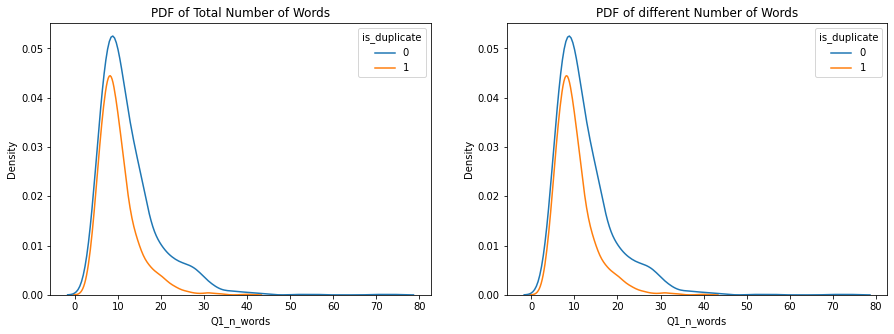

In [57]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Words')
sns.kdeplot(bf_df['Q1_n_words'], hue=bf_df.is_duplicate, ax=ax[0])
ax[1].title.set_text('PDF of different Number of Words')
sns.kdeplot(bf_df['Q1_n_words'], hue=bf_df.is_duplicate, ax=ax[1])
plt.show()

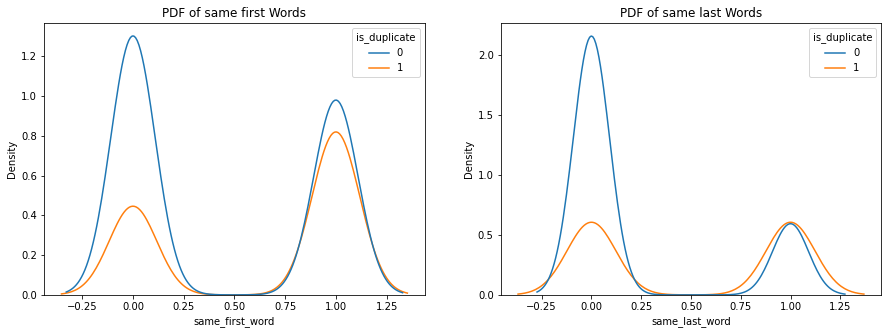

In [58]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of same first Words')
sns.kdeplot(bf_df['same_first_word'], hue=bf_df.is_duplicate, ax=ax[0])
ax[1].title.set_text('PDF of same last Words')
sns.kdeplot(bf_df['same_last_word'], hue=bf_df.is_duplicate, ax=ax[1])
plt.show()

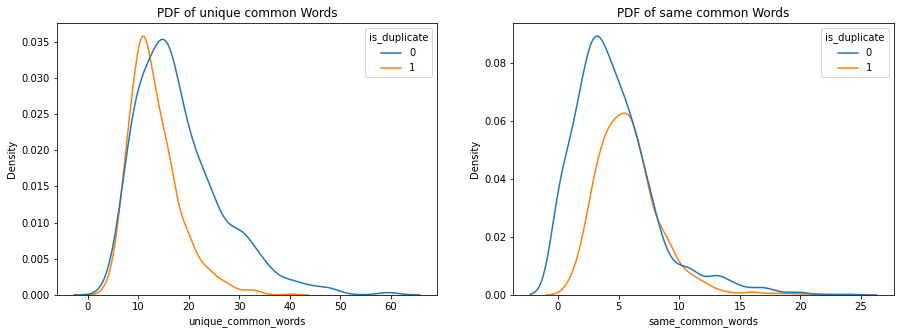

In [59]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of unique common Words')
sns.kdeplot(bf_df['unique_common_words'], hue=bf_df.is_duplicate, ax=ax[0])
ax[1].title.set_text('PDF of same common Words')
sns.kdeplot(bf_df['same_common_words'], hue=bf_df.is_duplicate, ax=ax[1])
plt.show()

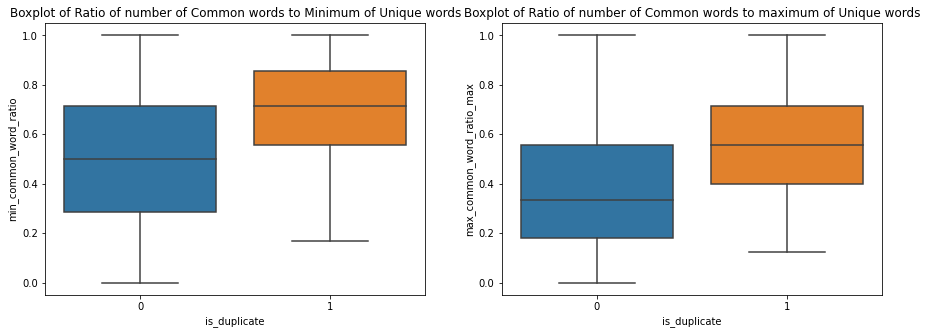

In [60]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Boxplot of Ratio of number of Common words to Minimum of Unique words')
sns.boxplot(x=bf_df.is_duplicate, y=bf_df['min_common_word_ratio'], ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to maximum of Unique words')
sns.boxplot(x=bf_df.is_duplicate, y=bf_df['max_common_word_ratio_max'],ax=ax[1])
plt.show()

# 2. StopWords and Tokens Features : 
*   **cwc_min** : Ratio of common_word_count to min length of word count of Q1 and Q2
*   **cwc_max** : Ratio of common_word_count to max length of word count of Q1 and Q2
*   **csc_min** : Ratio of common_stop_count to min length of stop count of Q1 and Q2
*   **csc_max** : Ratio of common_stop_count to max length of stop count of Q1 and Q2
*   **ctc_min** : Ratio of common_token_count to min length of token count of Q1 and Q2
*   **ctc_max** : Ratio of common_token_count to max length of token count of Q1 and Q2
*   **last_word_eq** : Check if Last word of both questions is equal or not
*   **first_word_eq** : Check if First word of both questions is equal or not
*   **abs_len_diff** : Abs. length difference
*   **mean_len** : Average Token Length of both Questions
*   **longest_substr_ratio** : Ratio of length longest common substring to min length of token count of Q1 and Q2

In [61]:
SW_df=pd.concat([new_df['question1'],new_df['question2'],new_df['is_duplicate']],axis=1)

In [62]:
SW_df.head()

,question1,question2,is_duplicate
398782,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [63]:
!pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import distance
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*11
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    # Absolute length features
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    token_features[10] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return token_features

In [65]:
token_features = new_df.apply(fetch_token_features, axis=1)

SW_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
SW_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
SW_df["csc_min"]       = list(map(lambda x: x[2], token_features))
SW_df["csc_max"]       = list(map(lambda x: x[3], token_features))
SW_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
SW_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
SW_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
SW_df["first_word_eq"] = list(map(lambda x: x[7], token_features))
SW_df['abs_len_diff']  = list(map(lambda x: x[8], token_features))
SW_df['mean_len']      = list(map(lambda x: x[9], token_features))
SW_df['longest_substr_ratio'] = list(map(lambda x: x[10], token_features))


In [66]:
SW_df.head()

,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,0.874989,0.874989,0.999975,0.999975,0.916659,0.916659,1,1,0,12.0,0.844156
115086,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,0.833319,0.714276,0.499988,0.333328,0.583328,0.466664,1,1,3,13.5,0.220000
327711,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,0.000000,0.000000,0.499988,0.285710,0.117646,0.080000,0,0,8,21.0,0.047170
367788,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,18,21.0,0.050000
151235,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,0.749981,0.499992,0.000000,0.000000,0.599988,0.333330,1,0,4,7.0,0.555556


> # Visualization of stopwords and tokens features

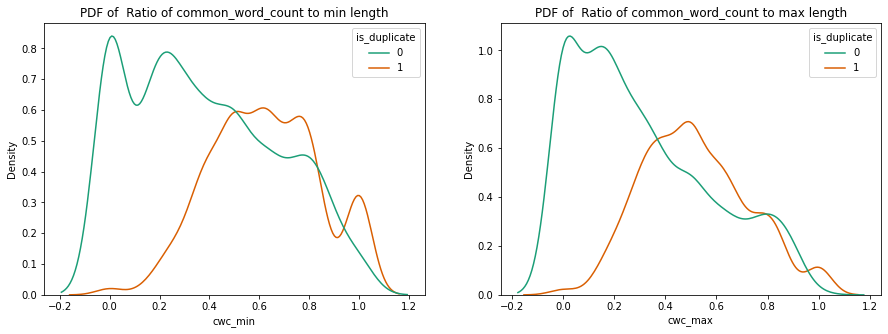

In [67]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of  Ratio of common_word_count to min length')
sns.kdeplot(SW_df['cwc_min'], hue=SW_df.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('PDF of  Ratio of common_word_count to max length')
sns.kdeplot(SW_df['cwc_max'], hue=SW_df.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

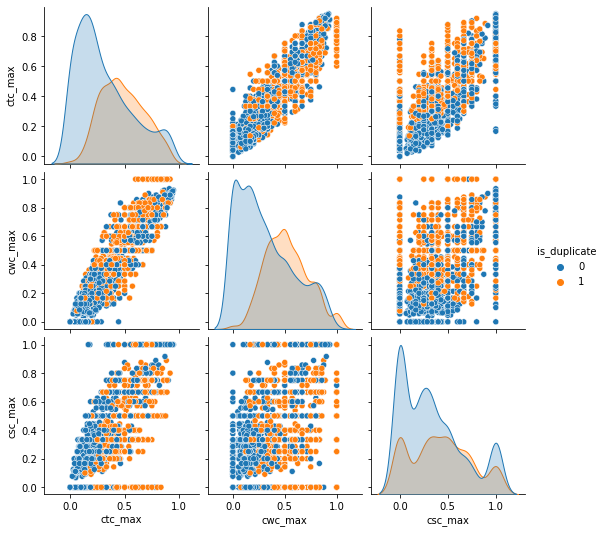

In [68]:
sns.pairplot(SW_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

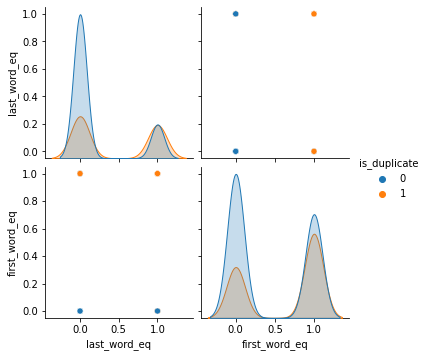

In [69]:
sns.pairplot(SW_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

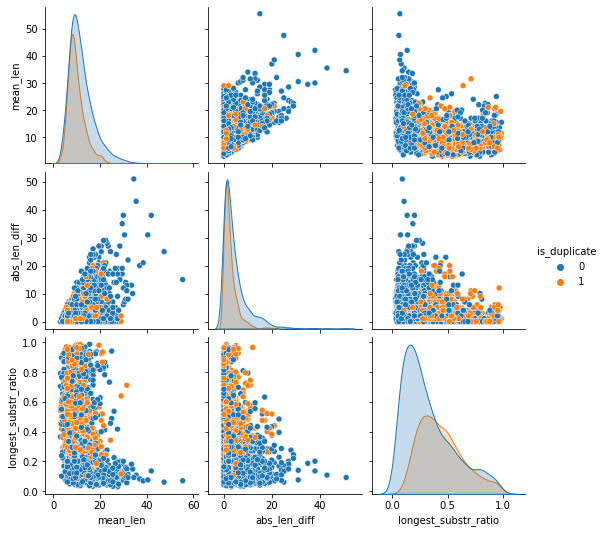

In [70]:
sns.pairplot(SW_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

#Observation: 
We can notice that the distribution of Stopword and tokens features are Overlapping for duplicate & Non-duplicate Question Pairs. 

So these features may not be useful in separating the duplicate & non-duplicate question pairs. Hence, we would not consider them for modelling.

> # 3. Fuzzy Features:
*      **fuzz_ratio** : fuzzyWuzzy has a ratio function that calculates the standard Levenshtein distance similarity ratio between two sequences.
*      **fuzz_partial_ratio** : The partial ratio helps us to perform substring matching. This takes the shortest string and compares it with all the substrings of the same length.
*      **token_set_ratio** : Token set ratio performs a set operation that takes out the common tokens instead of just tokenizing the strings, sorting, and then pasting the tokens back together. Extra or same repeated words do not matter.
*      **token_sort_ratio** : In token sort ratio, the strings are tokenized and pre-processed by converting to lower case and getting rid of punctuation. The strings are then sorted alphabetically and joined together. Post this, the Levenshtein distance similarity ratio is calculated between the strings.

In [71]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
fuzzy_df=pd.concat([new_df['question1'],new_df['question2'],new_df['is_duplicate']],axis=1)

In [73]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [74]:
fuzzy_features = fuzzy_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
fuzzy_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
fuzzy_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
fuzzy_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
fuzzy_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [75]:
fuzzy_df.head()

,question1,question2,is_duplicate,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,99,99,99,99
115086,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,69,67,65,74
327711,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,26,28,34,43
367788,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,29,37,23,30
151235,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,55,71,48,69


> Let's visualize above features.

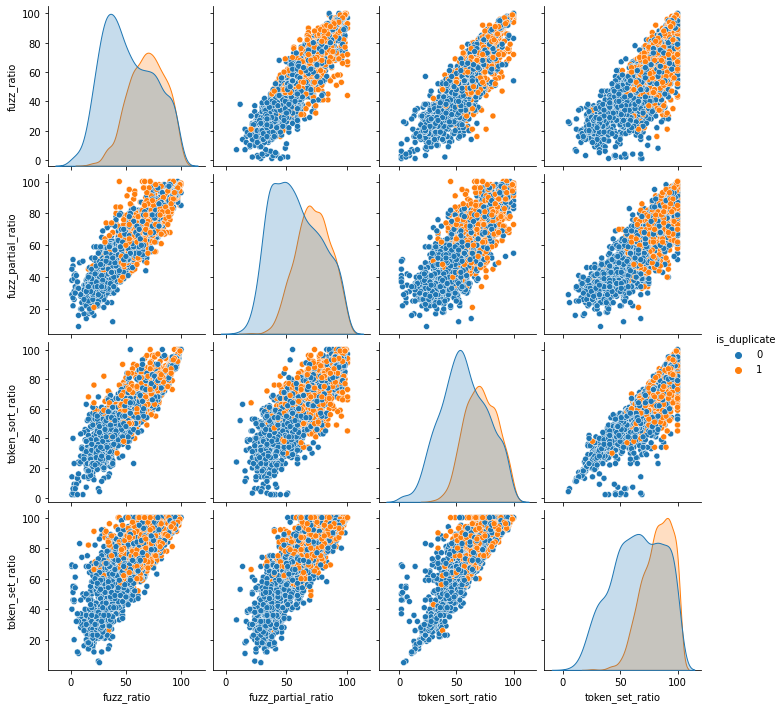

In [76]:
sns.pairplot(fuzzy_df,hue='is_duplicate')

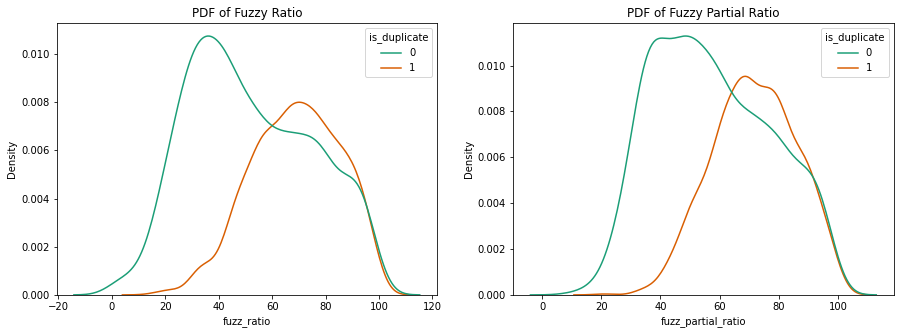

In [77]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzzy Ratio')
sns.kdeplot(fuzzy_df['fuzz_ratio'], hue=fuzzy_df.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('PDF of Fuzzy Partial Ratio')
sns.kdeplot(fuzzy_df['fuzz_partial_ratio'], hue=fuzzy_df.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

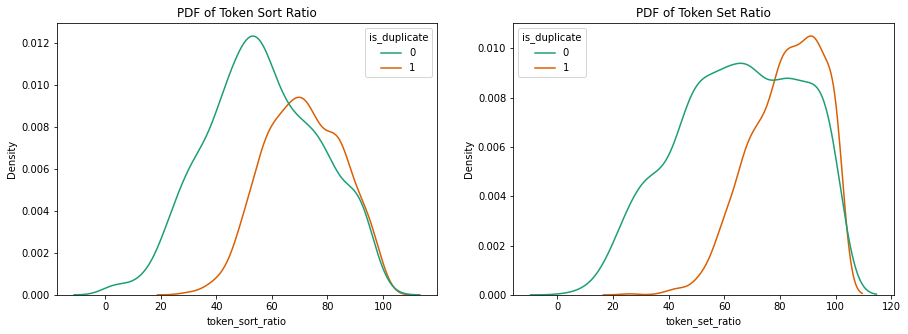

In [78]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Token Sort Ratio')
sns.kdeplot(fuzzy_df['token_sort_ratio'], hue=fuzzy_df.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('PDF of Token Set Ratio')
sns.kdeplot(fuzzy_df['token_set_ratio'], hue=fuzzy_df.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

In [79]:
feature_df=pd.concat([ new_df['id'],new_df[ 'qid1'], new_df['qid2'],new_df['Clean_q1_lem'],new_df[ 'Clean_q2_lem'],new_df[ 'is_duplicate'], bf_df1['q1_len'],bf_df1['q2_len'],bf_df1['q1_num_words'], bf_df1['q2_num_words'], 
       bf_df1['word_common'], bf_df1['word_total'], bf_df1['word_share'],SW_df['cwc_min'], SW_df['cwc_max'], SW_df['csc_min'], SW_df['csc_max'],
       SW_df['ctc_min'], SW_df['ctc_max'], SW_df['last_word_eq'], SW_df['first_word_eq'], SW_df['abs_len_diff'],SW_df['mean_len'], SW_df['longest_substr_ratio'],fuzzy_df['fuzz_ratio'], fuzzy_df['fuzz_partial_ratio'], fuzzy_df['token_sort_ratio'],fuzzy_df['token_set_ratio'] ],axis=1)
feature_df.columns

Index(['id', 'qid1', 'qid2', 'Clean_q1_lem', 'Clean_q2_lem', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'word_common',
       'word_total', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'longest_substr_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

In [84]:
from google.colab import files

feature_df.to_csv('feature_df.csv')
files.download('feature_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
from google.colab import files

feature_df.to_csv('feature_df.csv')
files.download('feature_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>